In [1]:
import sys
from pathlib import Path
path_root = '../'
sys.path.append(str(path_root))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from iblatlas.atlas import AllenAtlas
from utils.ibl_data_utils import (
    load_spiking_data, load_trials_and_mask, merge_probes,
    load_trial_behaviors, load_anytime_behaviors,
    prepare_data, 
    select_brain_regions, list_brain_regions, 
    bin_spiking_data, 
)

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


##### Data Loading Example (Single Session)

In [2]:
# Instantiate ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', 
          silent=True, 
          cache_dir='/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
)
one = ONE(password='international')
ba = AllenAtlas()

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/one/params.py:184: UserWarning: Warning: the directory provided is already a cache for another URL.
  warnings.warn('Warning: the directory provided is already a cache for another URL.')


In [3]:
# List all publicly available sessions
# sessions = one.search()

# List all sessions from the brain-wide-map project
# Note: Not all sessions will have behaviors recorded so we can use sessions 
#       w/ behaviors for supervised tasks and those w/o for SSL
# sessions = one.search(project='brainwide')

# List brainwide map sessions that pass the most important quality controls
# Note: Let's first work with these good quality sessions, and 
#       transition to using more sessions later on
freeze_file = '../data/2023_12_bwm_release.csv'
bwm_df = pd.read_csv(freeze_file, index_col=0)

In [4]:
# Load an example session
idx = 10
pid = bwm_df.pid[idx]
eid, probe = one.pid2eid(pid)

In [5]:
# Load spike sorting data
spikes, clusters = load_spiking_data(one, pid)

In [6]:
# We may not want to train the model with data within trials, but we may need it for eval purposes.
# Load trials data and mask. Trials are excluded in the mask if reaction time is too long or too short,
# or if critical trial events are missing.
trials, mask = load_trials_and_mask(one, eid, min_rt=0.08, max_rt=2., nan_exclude='default')

In [7]:
# Load behaviors for any-time decoding
anytime_behaviors = load_anytime_behaviors(one, eid)
print(anytime_behaviors.keys())

dict_keys(['wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])


##### Prepare Data for Any-Time Decoding (Single Session)

In [8]:
params = {
    'merged_probes': True,
    # setup for trial decoding:
    'align_time': 'stimOn_times',
    'time_window': (-.5, 1.5),
    'binsize': 0.02,
    'single_region': False # use all available regions
}

In [9]:
neural_dict, behave_dict, metadata = prepare_data(one, idx, bwm_df, params)

Running merged probes for session eid: 5ec72172-3901-4771-8777-6e9490ca51fc


In [10]:
neural_dict.keys()

dict_keys(['spike_times', 'spike_clusters', 'cluster_regions', 'cluster_qc', 'cluster_df'])

##### Prepare Data for Trial Decoding (Single Session)

In [11]:
regions, beryl_reg = list_brain_regions(neural_dict, **params)

Use spikes from brain regions:  ['ACAd' 'ACB' 'AON' 'DP' 'ILA' 'LSr' 'LSv' 'MOs' 'OT' 'PL' 'SI' 'TTd'
 'root']


In [12]:
region_cluster_ids = select_brain_regions(neural_dict, beryl_reg, regions, **params)

In [13]:
# 'binned_spikes' is very sparse - how to handle the tokenization more efficiently?
binned_spikes, clusters_used_in_bins = bin_spiking_data(region_cluster_ids, neural_dict, trials, **params)

100%|█████████████████████████████████████████| 721/721 [00:20<00:00, 35.26it/s]


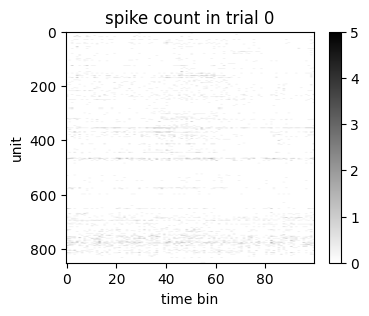

In [14]:
trial_idx = 0
plt.figure(figsize=(4,3))
plt.imshow(binned_spikes[trial_idx].T, aspect="auto", cmap="binary")
plt.title(f"spike count in trial {trial_idx}")
plt.xlabel("time bin")
plt.ylabel("unit")
plt.colorbar();

In [15]:
binned_behaviors = load_trial_behaviors(one, eid, trials, allow_nans=True, **params)
binned_behaviors.keys()

dict_keys(['choice', 'block', 'reward', 'contrast', 'wheel-position', 'wheel-velocity', 'wheel-speed', 'left-whisker-motion-energy', 'right-whisker-motion-energy', 'left-pupil-diameter', 'right-pupil-diameter', 'left-camera-left-paw-speed', 'left-camera-right-paw-speed', 'right-camera-left-paw-speed', 'right-camera-right-paw-speed', 'left-nose-speed', 'right-nose-speed'])

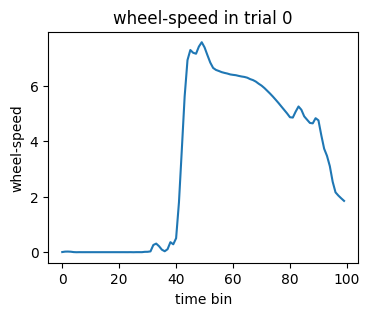

In [16]:
behave = "wheel-speed"
plt.figure(figsize=(4,3))
plt.plot(binned_behaviors[behave][trial_idx])
plt.title(f"{behave} in trial {trial_idx}")
plt.xlabel("time bin")
plt.ylabel(behave);

##### Download and Cache Data  (Multiple Sessions)